In [1]:
from load_data import get_sample
from PIL import Image
from stablediffusion import StableDiffusion
import torch
from vision_encoder import vision_encoder
from llm import ClipCaptionModel, generate_text_with_gumbel_softmax
import os
from transformers import GPT2Tokenizer, AdamW, CLIPProcessor, CLIPModel
import numpy as np
from fashion_clip.fashion_clip import FashionCLIP
from mapping import get_gpt2_logits, map_prompt_to_clip, recover_text_from_one_hot
from custom_clip import CustomCLIPTextModel 
from torchvision import transforms
import random
import gc

our_clip = CustomCLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="text_encoder")
sd = StableDiffusion()
encoder = vision_encoder()
fclip = FashionCLIP('fashion-clip')
CPU = torch.device('cpu')
device = 'cpu'
clip_vit = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_vit.to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

for param in clip_vit.parameters():
    param.requires_grad = False

#for param in sd.parameters():
#    param.requires_grad = False

/Users/ram/miniforge3/envs/vlrfashion/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ram/miniforge3/envs/vlrfashion/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
prefix_length = 10
current_directory = os.getcwd()
save_path = os.path.join(current_directory, "saved_models")
os.makedirs(save_path, exist_ok=True)

model = ClipCaptionModel(prefix_length)
model_path = os.path.join(save_path, 'coco_prefix-190.pt')
model.load_state_dict(torch.load(model_path, map_location=CPU)) 
model = model.eval() 
model = model.to(device)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

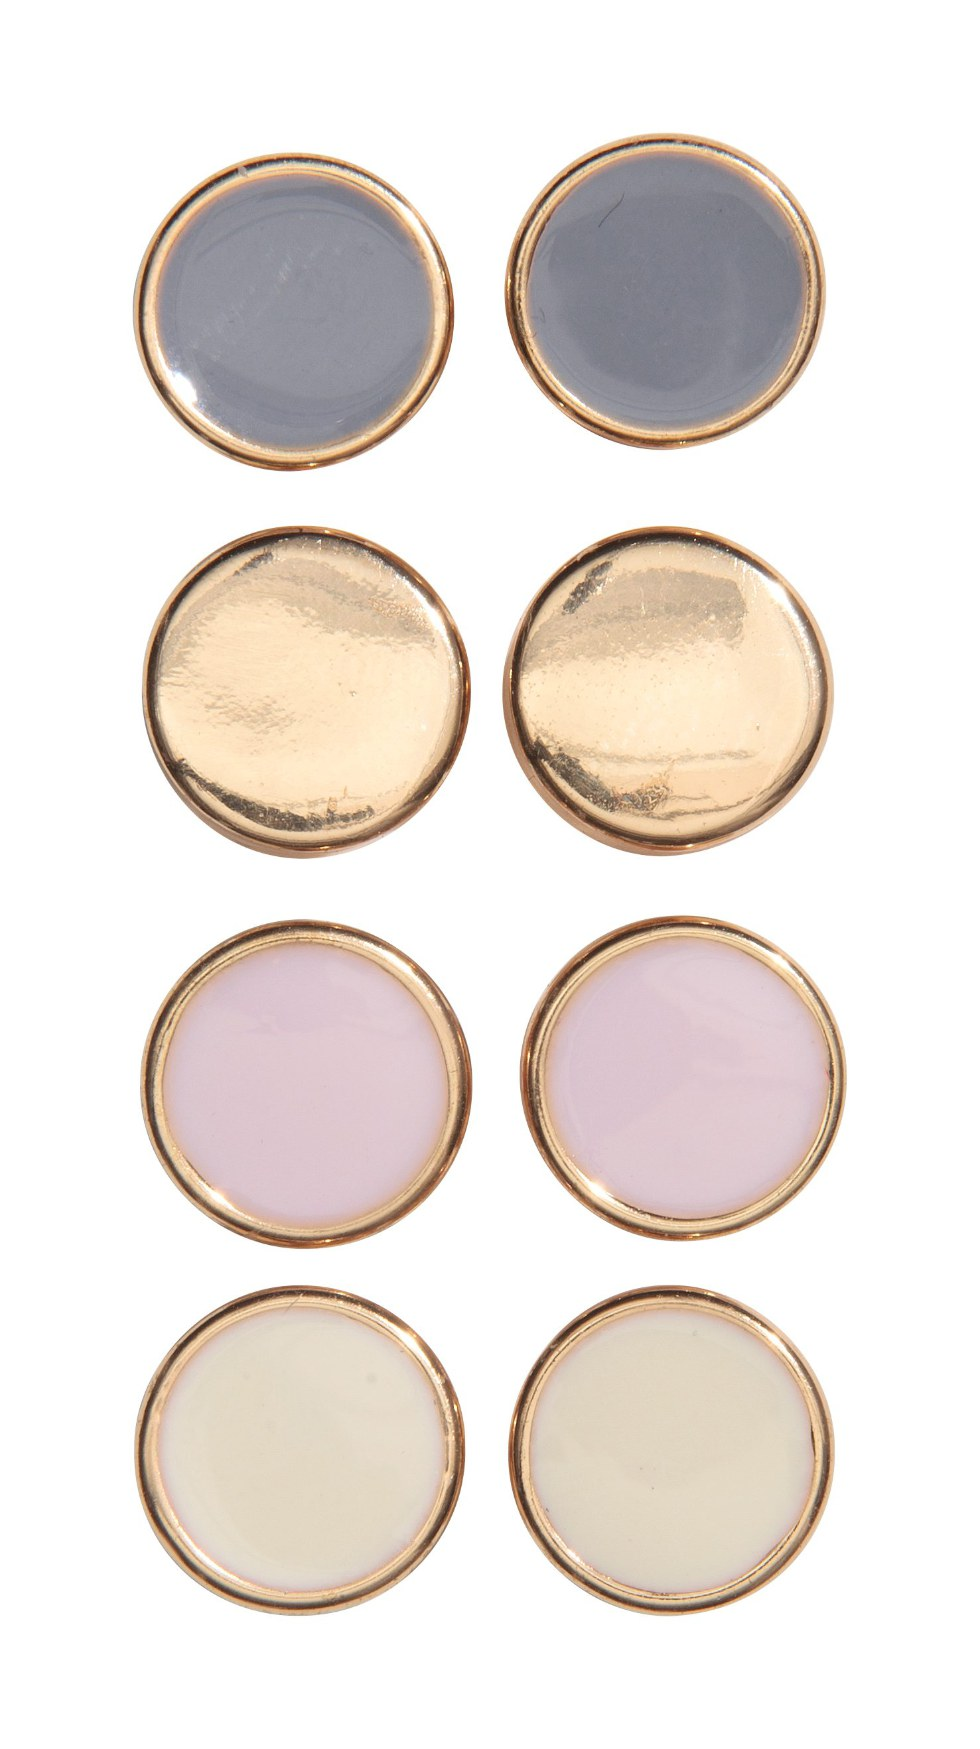

In [19]:

# get random number
def get_random_number():
    return random.randint(0, 1000)
i = get_random_number()

pil_image, row = get_sample(i)
display(pil_image)

In [7]:
pil_image, row = get_sample()

# Encode images and prepare embeddings
image_embeddings = fclip.encode_images([pil_image], batch_size=1)
image_embeddings /= np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
image_embeddings = torch.tensor(image_embeddings, device=device, dtype=torch.float32)

# Ensure gradients are computed for embeddings part
image_embeddings.requires_grad_(True)

prefix_embed = model.clip_project(image_embeddings).reshape(1, prefix_length, -1)
out, soft_tokens_list = generate_text_with_gumbel_softmax(model, tokenizer, embed=prefix_embed, temperature=0.1)
out

100%|██████████| 1/1 [00:00<00:00,  7.19it/s]


'Black Jersey top with narrow shoulder straps. Unlined. The polyamide content of the top is partly recycled. The top is designed with the minimum number of seams for a more comfortable fit and increased mobility. For the matching colour, look for 0683740. The polyester content of the lining is recycled. The polyester content'

In [ ]:
def compute_clip_loss(pil_image, output_tensor):
    def prepare_image(image, device, is_tensor=False):
        if is_tensor:
            # Apply normalization directly to tensor
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            image = transform(image)  # Assumes image is already a tensor
        else:
            # Convert PIL Image to tensor and apply transformations
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            image = transform(image).to(device)
        return image.unsqueeze(0)

    # Process the PIL image and the output tensor
    pil_tensor = prepare_image(pil_image, device)
    output_tensor = output_tensor.permute(0, 1, 2)  # Convert to [C, H, W] if not already
    output_tensor = prepare_image(output_tensor, device, is_tensor=True)

    # Get CLIP features
    features_pil = clip_vit.get_image_features(pixel_values=pil_tensor)
    features_output = clip_vit.get_image_features(pixel_values=output_tensor)

    # Calculate MSE Loss
    mse_loss = torch.nn.MSELoss()
    loss = mse_loss(features_pil, features_output)

    return loss

In [ ]:
for name, parameter in model.named_parameters():
    param.requires_grad = True  # Ensure all parameters are trainable

In [ ]:
# Set up the optimizer with only those parameters that need to be updated
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)

# Example loop for processing and training
num_training_steps = 100
for step in range(num_training_steps):
    pil_image, row = get_sample(0)

    # Encode images and prepare embeddings
    image_embeddings = fclip.encode_images([pil_image], batch_size=1)
    image_embeddings /= np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
    image_embeddings = torch.tensor(image_embeddings, device=device, dtype=torch.float32)

    # Ensure gradients are computed for embeddings part
    image_embeddings.requires_grad_(True)

    prefix_embed = model.clip_project(image_embeddings).reshape(1, prefix_length, -1)
    out, soft_tokens_list = generate_text_with_gumbel_softmax(model, tokenizer, embed=prefix_embed, temperature=0.1)
    
    print(f"Prompt: {out}")

    combined_softmax_outputs = torch.cat(soft_tokens_list, dim=0)
    tokens, attention_mask, input_ids, out_prompt = map_prompt_to_clip(combined_softmax_outputs)
    token_embeddings = our_clip(inputs_embeds=tokens.unsqueeze(0), attention_mask=attention_mask, input_ids = input_ids.unsqueeze(0))[0]
    sd.requires_grad_(False)
    output = sd([out_prompt], tokens=token_embeddings.to(device), num_inference_steps=1)
    loss = compute_clip_loss(pil_image, output)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Step {step} Loss: {loss.item()}")
    
    del pil_image, row, image_embeddings, prefix_embed, out, combined_softmax_outputs, tokens, attention_mask, input_ids, token_embeddings, output, loss
    torch.cuda.empty_cache()  # Clear CUDA cache
    gc.collect()
    
    print(f"Step {step}: Gradients for LLM (model)")


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Prompt: Body in crushed velvet with thin shoulder straps and a narrow crossover fastening at the back. Narrow, adjustable shoulder straps and spaghetti straps at the back. Unlined. The polyester content of the bra is partly recycled. For the matching sweatshirt, search on 02224.2.Fully lined. For other matching sweats


/home/ec2-user/SageMaker/llm_diffusion/mapping.py:59: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1696595231861/work/torch/csrc/utils/tensor_new.cpp:605.)
  transformation_matrix = torch.sparse.FloatTensor(indices, values, torch.Size([gpt2_vocab_size, clip_vocab_size]))


  0%|          | 0/1 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Step 0 Loss: 0.22846709191799164
Step 0: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Prompt: Body in crushed velvet with thin shoulder straps and a narrow crossover fastening at the back with two pairs of hooks and eyes. A rounded hem. Partly lined in jersey. Unlined. The polyester content of the bodysuits is partly recycled. For matching top dress press-studs, search on 044158.


  0%|          | 0/1 [00:00<?, ?it/s]

Step 1 Loss: 0.22850888967514038
Step 1: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


Prompt: Body in crushed velvet with thin shoulder straps and a narrow crossover at the back with a shaping seam at the top. Narrow spaghetti straps, wide shoulder straps and decorative scalloped trim around the hem. Unlined. Unlined. The polyester content of the top layer is partly recycled. For technical reasons, we continue to use


  0%|          | 0/1 [00:00<?, ?it/s]

Step 2 Loss: 0.2284720242023468
Step 2: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Prompt: Body in crushed velvet with thin sleeves, a concealed zip at the back and narrow shoulder straps at the back. Narrow draping at the top for best fit, and a bell-shaped skirt. Unlined. Unlined. The polyester content of the top layer is partly recycled. For technical reasons, we continue to make


  0%|          | 0/1 [00:00<?, ?it/s]

Step 3 Loss: 0.22846096754074097
Step 3: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


Prompt: Body in crushed velvet with thin sleeves, a concealed zip at the back and narrow shoulder straps at the back. Narrow draping at the top for best fit, and flared skirt with ribbed trims. Unlined. Size 20x27 cm. The top 50.5% of the sales. Super push-up.


  0%|          | 0/1 [00:00<?, ?it/s]

Step 4 Loss: 0.22847867012023926
Step 4: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


Prompt: Body in spaghetti velvet with thin sleeves, a concealed zip at the back and narrow shoulder straps at the back. Narrow draping at the top for best fit, a seam under the bust and a rounded hem. Unlined. Unlined. The polyester content of the dress is partly recycled. For more information, see:


  0%|          | 0/1 [00:00<?, ?it/s]

Step 5 Loss: 0.22848455607891083
Step 5: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


Prompt: Body in crushed velvet with thin sleeves, a concealed zip at the back and narrow shoulder straps at the back. Narrow draping at the top for best fit, a seam under the bust and a rounded hem. Unlined. Unlined. Unlined. Unlined. All in the shape of spaghetti. Regular Fit – a


  0%|          | 0/1 [00:00<?, ?it/s]

Step 6 Loss: 0.2284753918647766
Step 6: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Prompt: Body in crushed velvet with thin sleeves, a concealed zip at the back and bell-shaped skirt. Narrow shoulder straps and spaghetti straps at the cuffs. Unlined. Unlined. Soft brushed inside. Lined. The polyester content of the dress is partly recycled. For the matching dress, search on 050 2045


  0%|          | 0/1 [00:00<?, ?it/s]

Step 7 Loss: 0.22845226526260376
Step 7: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


Prompt: Body in spaghetti straps with thin sleeves, a concealed zip at the back and bell-shaped skirt. Narrow shoulder straps and spaghetti straps at the cuffs. Unlined. Unlined. Soft brushed inside. Lined. The dress has a high waist and medium coverage at the back. Lined at the top. Lined at


  0%|          | 0/1 [00:00<?, ?it/s]

Step 8 Loss: 0.2284795343875885
Step 8: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


Prompt: Body in spaghetti and soft jersey with spaghetti straps that cross at the back and narrow shoulder straps at the back. Narrow elastication at the waist for a good fit over the tummy, a concealed zip at the back and spaghetti straps at the top. Lined g. Unlined. Jersey underdress. Unlined. Jersey


  0%|          | 0/1 [00:00<?, ?it/s]

Step 9 Loss: 0.2284739911556244
Step 9: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.10it/s]


Prompt: Body in spaghetti and soft jersey with spaghetti straps that cross at the back and bell-shaped skirt with a decorative seam at the hem. Narrow shoulder straps, spaghetti straps around the neckline, a seam at the crotch with spaghetti straps at the back and flared skirt. Lined at the front. Lined at the back. Un


  0%|          | 0/1 [00:00<?, ?it/s]

Step 10 Loss: 0.22845739126205444
Step 10: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


Prompt: Body in spaghetti and soft jersey with spaghetti straps that cross at the back and bell-shaped skirt with a decorative seam at the hem. Narrow shoulder straps, spaghetti straps around the neckline, a seam at the crotch with spaghetti straps at the back and flared skirt. Lined at the front. Lined at the back. Un


  0%|          | 0/1 [00:00<?, ?it/s]

Step 11 Loss: 0.22845888137817383
Step 11: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


Prompt: Body in spaghetti and soft jersey with spaghetti straps that cross at the back and bell-shaped skirt with a decorative seam at the hem. Narrow shoulder straps, spaghetti straps around the neckline, a seam at the crotch with spaghetti straps at the back and flared skirt. Lined at the front. Lined at the back. Un


  0%|          | 0/1 [00:00<?, ?it/s]

Step 12 Loss: 0.2284284383058548
Step 12: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Prompt: Body in spaghetti and soft jersey with spaghetti straps, a close-fitting, bell-shaped dress with gathers decorative opening at the back and spaghetti straps with ties at the back of the neck. Narrow spaghetti straps at the shoulders and a narrow lace at the waist with a zip at the back and spaghetti straps. Lined mouth with spaghetti


  0%|          | 0/1 [00:00<?, ?it/s]

Step 13 Loss: 0.2284606248140335
Step 13: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


Prompt: Body in spaghetti and soft viscose jersey with a V-neck, pleats and long sleeves with sewn-in turn-ups, a seam at the waist, a flared skirt with ribbed trims, a high cut at the hem and spaghetti straps with lacing at the front and decorative button. Narrow cut at the


  0%|          | 0/1 [00:00<?, ?it/s]

Step 14 Loss: 0.22848445177078247
Step 14: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


Prompt: Body in spaghetti and soft viscose jersey with a V-neck, pleats and long sleeves with sewn-in turn-ups, a seam at the waist, a flared skirt with ribbed trims, a high cut at the hem and spaghetti straps with lacing. All-over print, spaghetti sleeves, a concealed zip


  0%|          | 0/1 [00:00<?, ?it/s]

Step 15 Loss: 0.22847683727741241
Step 15: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


Prompt: Body in spaghetti and soft viscose jersey with a V-neck, pleats and long sleeves with sewn-in turn-ups, a seam at the waist, a flared skirt with ribbed trims, a high cut at the hem and spaghetti straps with lacing at the front and decorative button. Searrow cut at the


  0%|          | 0/1 [00:00<?, ?it/s]

Step 16 Loss: 0.2284729778766632
Step 16: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


Prompt: Body in spaghetti and soft viscose jersey with a V-neck, pleats and long sleeves. Partly lined in jersey, sleeves, seam at the waist and flared skirt. Partly lined in jersey, spaghetti and high cut at the chest. Lined at the top. All-over print, a wide neckline, cut


  0%|          | 0/1 [00:00<?, ?it/s]

Step 17 Loss: 0.22846901416778564
Step 17: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.30it/s]


Prompt: Body in spaghetti and soft viscose jersey with a V-neck, pleats and raw-edge, frilled collar, spaghetti sleeves, seam at the waist and flared skirt. Partly lined in jersey. Long sleeves with ribbed cuffs and raw-edge hem. Lined. Hat with an integral seam. Lined.


  0%|          | 0/1 [00:00<?, ?it/s]

Step 18 Loss: 0.22847992181777954
Step 18: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.01it/s]


Prompt: Body in spaghetti and soft viscose jersey with a V-neck, pleats and raw-edge front, opening with covered buttons at the neck and concealed zip in the side. Partly lined in jersey. Long sleeves with ribbed cuffs and raw edges, a zip at the back and seam at the waist. Lined.


  0%|          | 0/1 [00:00<?, ?it/s]

Step 19 Loss: 0.22846904397010803
Step 19: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Prompt: Body in spaghetti and soft viscose jersey with a V-neck, pleats and raw-edge front, opening and draping, and sleeves in a contrasting colour. Partly lined in jersey underdress. Narrow cut at the chest and sleeves, and a zip at the cuffs. Lined. Short shorts. V


  0%|          | 0/1 [00:00<?, ?it/s]

Step 20 Loss: 0.22846822440624237
Step 20: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


Prompt: Body in spaghetti and soft viscose jersey, a V-neck, raw edge and long sleeves. Partly lined in jersey, sleeves, a seam at the waist, skinny legs and jersey ribbing. Satin lining. Satin inset peplum. Leggings and woven inset at the sides. Lined.


  0%|          | 0/1 [00:00<?, ?it/s]

Step 21 Loss: 0.22844338417053223
Step 21: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


Prompt: Body in spaghetti and soft viscose jersey with a V-neck, raw edge and long sleeves. Partly lined in jersey, sleeves and a wider waist in imitation suede. Partly lined in jersey, slits in the sides and a rounded hem. Partly lined in jersey, short sleeves and a wide neckline. N


  0%|          | 0/1 [00:00<?, ?it/s]

Step 22 Loss: 0.2284146398305893
Step 22: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


Prompt: V-neck jumpsuit in soft, loose-fitting spaghetti V-neck, dress, lightly padded front and back and all-over print. Long sleeves, spaghetti at the front and raw edges at the cuffs and hem. Narrow open at the back, seam at the waist and flared skirt. Partly lined in Bodys


  0%|          | 0/1 [00:00<?, ?it/s]

Step 23 Loss: 0.22845084965229034
Step 23: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


Prompt: V-neck spaghetti-patterned spaghetti and spaghetti and spaghetti V-neck playsuit, spaghetti bolero shorts, spaghetti cap and spaghetti belt. Long sleeves, spaghetti fly and spaghetti spaghetti fly with a wide tie. Satin lining at the top and spaghetti pleats. Partly lined in spaghetti. V-neck spaghetti shorts, spaghetti


  0%|          | 0/1 [00:00<?, ?it/s]

Step 24 Loss: 0.2284473478794098
Step 24: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Prompt: V-neck spaghetti spaghetti spaghetti, spaghetti tunic and spaghetti uppers, spaghetti shoulder straps, spaghetti underskirt and spaghetti spaghetti fly. Zip and spaghetti fly, spaghetti shoulder straps and spaghetti spaghetti legs. Scalloped spaghetti sleeves and spaghetti flare. Lined. Leggings and spaghetti straps. Slim fit. For the matching trousers


  0%|          | 0/1 [00:00<?, ?it/s]

Step 25 Loss: 0.22846481204032898
Step 25: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


Prompt: V-neck spaghetti spaghetti spaghetti tun spaghetti tunic spaghetti spaghetti spaghetti spaghetti tunic spaghetti spaghetti spaghetti tunic spaghetti spaghetti spaghetti tunic spaghetti spaghetti tunic spaghetti tunic spaghetti spaghetti spaghetti spaghetti tunic spaghetti spaghetti tie spaghetti tunic spaghetti tie spaghetti tie spaghetti tunic spaghetti tie spaghetti tunic spaghetti tie spaghetti tunic spaghetti tie spaghetti tunic


  0%|          | 0/1 [00:00<?, ?it/s]

Step 26 Loss: 0.22841820120811462
Step 26: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


Prompt: V-neck spaghetti tunic in spaghetti tunic nylon, spaghetti, spaghetti edge and spaghetti-striped spaghetti sleeves. Detachable spaghetti lin, spaghetti straps, spaghetti straps and spaghetti bellos at the hems. Slim fit. Unlined. 200 denier. Tunic in spaghetti tunic nylon with a zip in one side.


  0%|          | 0/1 [00:00<?, ?it/s]

Step 27 Loss: 0.22844238579273224
Step 27: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


Prompt: V-neck spaghetti tunic in spaghetti tunic nylon, spaghetti fly, spaghetti shoulder straps, spaghetti fly with a bell placket, spaghetti fly and spaghetti flystring, skinny legs and spaghetti shoulder strap. Tapered legs with spaghetti hems and spaghetti fly and spaghetti elbows. Lined at the top, spaghetti wide jersey underskirt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 28 Loss: 0.22845274209976196
Step 28: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Prompt: V-neck spaghetti tunic, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt,


  0%|          | 0/1 [00:00<?, ?it/s]

Step 29 Loss: 0.22846324741840363
Step 29: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.00it/s]


Prompt: V-neck spaghetti tunic, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt,


  0%|          | 0/1 [00:00<?, ?it/s]

Step 30 Loss: 0.22846388816833496
Step 30: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Prompt: V-neck jumps in spaghetti, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt,


  0%|          | 0/1 [00:00<?, ?it/s]

Step 31 Loss: 0.228461354970932
Step 31: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


Prompt: V-neck jumpsuit in spaghetti, spaghetti belt, spaghetti belt, spaghetti belt trousers, spaghetti belt with, spaghetti belt trousers, spaghetti belt belt sleeves, spaghetti belt belt belt belt at the waist, spaghetti belt slits in the sides and a zip fly and bell-shaped press-stud, spaghetti belt belt wide legs and spaghetti belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 32 Loss: 0.22848382592201233
Step 32: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.04it/s]


Prompt: V-neck jumpsuit in spaghetti belt, spaghetti belt belt, spaghetti belt belt belt belt, spaghetti belt belt belt belt, spaghetti belt belt belt, spaghetti belt buckle, skinny-fit belt, spaghetti belt, spaghetti belt buckle, spaghetti belt belt buckle, boxer belt, spaghetti belt belt belt belt, spaghetti belt belt belt buckle, spaghetti


  0%|          | 0/1 [00:00<?, ?it/s]

Step 33 Loss: 0.22841773927211761
Step 33: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


Prompt: V-neck jumpsuit yoga belt, spaghetti belt, spaghetti belt, spaghetti belt belt belt belt belt belt belt belt buckle all-over belt belt, spaghetti fly, spaghetti belt buckle tattoos on the back and fake front pockets, regular waist, spaghetti belt belt and spaghetti belt belt press-studs, back pockets and spaghetti belt belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 34 Loss: 0.22845840454101562
Step 34: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


Prompt: V-neck jumpsuit in spaghetti belt, spaghetti belt belt belt, spaghetti belt belt belt belt belt with adjustable press-studs, spaghetti belt belt belt belt belt, skinny belt belt, spaghetti belt belt belt belt belt buckle, spaghetti belt belt belt buckle, spaghetti belt belt belt belt belt belt buckle, spaghetti belt belt buckle buckle,


  0%|          | 0/1 [00:00<?, ?it/s]

Step 35 Loss: 0.22841079533100128
Step 35: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Prompt:  j3/4-length spaghetti belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt mouth belt,


  0%|          | 0/1 [00:00<?, ?it/s]

Step 36 Loss: 0.22834935784339905
Step 36: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


Prompt:  Short shorts in spaghetti belt, spaghetti belt belt belt, spaghetti belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti


  0%|          | 0/1 [00:00<?, ?it/s]

Step 37 Loss: 0.2283831387758255
Step 37: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


Prompt:  Short shorts in spaghetti belt, spaghetti belt belt belt, spaghetti belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti belt belt belt belt belt, spaghetti


  0%|          | 0/1 [00:00<?, ?it/s]

Step 38 Loss: 0.22838282585144043
Step 38: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


Prompt:  Short shorts in spaghetti belt, spaghetti belt belt belt belt belt belt, spaghetti belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt mouth belt,


  0%|          | 0/1 [00:00<?, ?it/s]

Step 39 Loss: 0.22835911810398102
Step 39: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


Prompt:  Short shorts in spaghetti belt belt, spaghetti belt belt, spaghetti belt, spaghetti belt belt belt, spaghetti belt belt belt, spaghetti belt, belt belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti


  0%|          | 0/1 [00:00<?, ?it/s]

Step 40 Loss: 0.22842176258563995
Step 40: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.24it/s]


Prompt:  Short shorts in spaghetti belt belt, spaghetti belt belt, spaghetti belt, spaghetti belt belt belt, spaghetti belt belt belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti belt, spaghetti


  0%|          | 0/1 [00:00<?, ?it/s]

Step 41 Loss: 0.22842815518379211
Step 41: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


Prompt:  V top jumpsuit belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt mouth belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 42 Loss: 0.2283647060394287
Step 42: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.37it/s]


Prompt:  V top jumpsuit belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 43 Loss: 0.2283623218536377
Step 43: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


Prompt:  Short top jumpsuit belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 44 Loss: 0.22837141156196594
Step 44: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Prompt:  Short shorts in spaghetti belt belt, spaghetti belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 45 Loss: 0.22835510969161987
Step 45: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.29it/s]


Prompt:  Short shorts in spaghetti belt belt, spaghetti belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 46 Loss: 0.22835777699947357
Step 46: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


Prompt:  Short shorts in spaghetti belt belt, spaghetti belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 47 Loss: 0.22835668921470642
Step 47: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.39it/s]


Prompt:  Short shorts in spaghetti belt belt, spaghetti belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 48 Loss: 0.22835686802864075
Step 48: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


Prompt:  Short shorts in spaghetti belt belt, spaghetti belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt belt


  0%|          | 0/1 [00:00<?, ?it/s]

Step 49 Loss: 0.22835630178451538
Step 49: Gradients for LLM (model)


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


In [ ]:
def show_image(output):
    output_image = (output.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    output_image = Image.fromarray(output_image)
    output_image.show()

show_image(output)

In [ ]:
import torch

# Ensure CUDA is available
if torch.cuda.is_available():
    # Select your CUDA device, generally 0 by default for single-GPU setups
    device = torch.device('cuda:0')
    
    # Get GPU details
    total_memory = torch.cuda.get_device_properties(device).total_memory
    allocated_memory = torch.cuda.memory_allocated(device)
    cached_memory = torch.cuda.memory_reserved(device)
    max_allocated_memory = torch.cuda.max_memory_allocated(device)
    max_cached_memory = torch.cuda.max_memory_reserved(device)

    # Convert bytes to gigabytes for easier interpretation
    gb_divisor = 1024**3

    print(f"Total Memory: {total_memory / gb_divisor:.2f} GB")
    print(f"Allocated Memory: {allocated_memory / gb_divisor:.2f} GB")
    print(f"Cached Memory: {cached_memory / gb_divisor:.2f} GB")
    print(f"Max Allocated Memory: {max_allocated_memory / gb_divisor:.2f} GB")
    print(f"Max Cached Memory: {max_cached_memory / gb_divisor:.2f} GB")
else:
    print("CUDA is not available. Check your installation or GPU availability.")
